In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from z3 import *
import torch
import time
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from itertools import combinations, permutations

from Z3_Tools import *
from utils import *
from models import * 

# updated ...

## Z3 Logic

In [21]:
s = Solver()
s.add(parse("A|B"))
s.add(parse("A->C"))
s.add(parse("B->C"))
s.add(Not(parse("C")))

print(s.check())

unsat


In [22]:
## Test Verifier 
known = ["A|B", "A->C"]
proposal = "C"

is_valid = verify_step(known, proposal)
print("Is the step valid?", is_valid)

Is the step valid? False


# Enumerate Propositional Logic Statements

In [23]:
## Generate all_formulas more cleverly 
ATOMS = ["A", "B", "C", "D", "E"] 

lits = ATOMS + [f"~{a}" for a in ATOMS]
imps = [f"{p}->{q}" for p, q in permutations(ATOMS, 2)]      
ands = [f"{p}&{q}"   for p, q in combinations(ATOMS, 2)]  
ors  = [f"{p}|{q}"   for p, q in combinations(ATOMS, 2)] 

ALL_FORMULAS = lits + imps + ands + ors
print(np.array(ALL_FORMULAS))
print(len(ALL_FORMULAS))

['A' 'B' 'C' 'D' 'E' '~A' '~B' '~C' '~D' '~E' 'A->B' 'A->C' 'A->D' 'A->E'
 'B->A' 'B->C' 'B->D' 'B->E' 'C->A' 'C->B' 'C->D' 'C->E' 'D->A' 'D->B'
 'D->C' 'D->E' 'E->A' 'E->B' 'E->C' 'E->D' 'A&B' 'A&C' 'A&D' 'A&E' 'B&C'
 'B&D' 'B&E' 'C&D' 'C&E' 'D&E' 'A|B' 'A|C' 'A|D' 'A|E' 'B|C' 'B|D' 'B|E'
 'C|D' 'C|E' 'D|E']
50


In [24]:
# Define ALL_STATES from many random subsets of ALL_FORMULAS
# Ignore false states (check this by ensuring a -> false is false, which means a is true) 
N = 200_000; ALL_STATES = set(); 
while len(ALL_STATES) < N: 
    subset = frozenset(random_subset(ALL_FORMULAS, 1, 5))
    if not verify_step(list(subset), "A & ~A"): 
        ALL_STATES.add(subset)
print(len(ALL_STATES))

200000


In [25]:
# # Loop over pairs of (states, formulae) and give them T/F labels   (skip this block for the money plot !! ) 
# # Try to get even number of 1, 2, 3, 4, 5 - step proofs?   ... maybe not smart for training ... 
temporary_cap = 100
total = len(list(ALL_STATES)[:temporary_cap]) * len(ALL_FORMULAS)
X_states, X_props, Y_labels = [], [], []
count = 0

for known in list(ALL_STATES)[:temporary_cap]:
    known = list(known)
    for prop in ALL_FORMULAS:
        label = verify_step(known, prop)
        
        X_states.append(known)
        X_props.append(prop)
        Y_labels.append(int(label))
        count += 1
        if count % 5000 == 0:
            print(f"{count} / {total} samples done")

5000 / 5000 samples done


# Train on Prop Logic

In [26]:
# Define one-hot-encoding map and state encoder 
OneHot_Map = {f:i for i,f in enumerate(ALL_FORMULAS)}

# Map X_props, X_states to One-Hot 
X_props_Map = np.array([OneHot_Map[p] for p in X_props])
X_props_1h = np.eye(len(ALL_FORMULAS))[X_props_Map]  # basically defining a repeating list of I rows ... 
X_states_1h = np.array([encode_state(s, ALL_FORMULAS) for s in X_states])

print(X_props[8])
print(X_props_Map[15])
print(X_props_1h[15])
print(X_states[15])
print(X_states_1h[5])

~D
15
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
['D|E', 'B->C', 'B&E', 'A&D', 'B&D']
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1.]


0 0.6981602907180786
50 0.49892064929008484
100 0.3086775243282318
150 0.0910666361451149
200 0.023519400507211685
250 0.007988765835762024


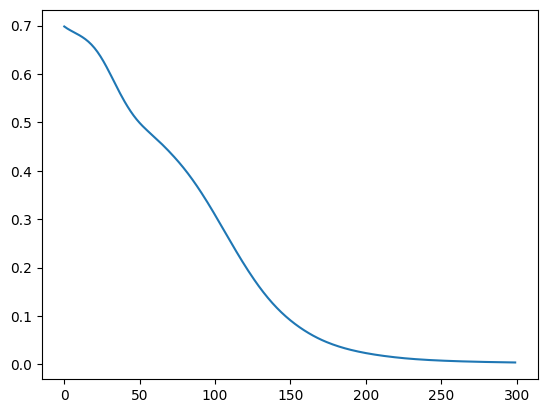

In [27]:
## Define X, Y, train/test split 
X = np.concatenate([X_props_1h, X_states_1h], axis=1)
Y = np.array(Y_labels).astype(float)
Xtr, Xte, ytr, yte = train_test_split(X, Y, test_size=0.2, random_state=0)

## Define model 
model = nn.Sequential(
    nn.Linear(X.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

## Train
Xt = torch.tensor(Xtr, dtype=torch.float32)
yt = torch.tensor(ytr, dtype=torch.float32).unsqueeze(1)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

losses = []
for epoch in range(300):
    opt.zero_grad()
    ypred = model(Xt)
    loss = loss_fn(ypred, yt)
    loss.backward()
    opt.step()
    if epoch%50==0: print(epoch, loss.item())
    losses.append(loss.item())

plt.plot(losses);

In [28]:
# Eval 
with torch.no_grad():
    Xtest = torch.tensor(Xte, dtype=torch.float32)
    ytest = torch.tensor(yte, dtype=torch.float32).unsqueeze(1)
    preds = (model(Xtest) > 0.5).float()
    acc = (preds == ytest).float().mean()

print("Test accuracy:", acc.item())

Test accuracy: 0.9330000281333923


# Baby Theorem Prover

In [29]:
testinput = np.concatenate([encode_state(['A', 'C'], ALL_FORMULAS), encode_state(['B'], ALL_FORMULAS)])
torch_input = torch.tensor([testinput], dtype=torch.float32)
test_output = model(torch_input)
print(test_output.item())

0.1248602643609047


In [30]:
def TheoremProver(state, objective, model, ALL_FORMULAS): 
    while objective not in state: 
        winner = pick_valid_step(state, model, ALL_FORMULAS, 10)[0]
        if winner is None: 
            print("No valid step found. Proof failed.")
            return None
        print(f'NN guess : {winner}')
        state.append(winner)
        print(f'New state: {state}')
    print('Proved!')

In [31]:
TheoremProver(['A', 'A->B', 'B->C'], 'C', model, ALL_FORMULAS)
TheoremProver(['A', 'A->B', 'B->C', 'C->D'], 'D', model, ALL_FORMULAS)


NN guess : B&C
New state: ['A', 'A->B', 'B->C', 'B&C']
NN guess : A&C
New state: ['A', 'A->B', 'B->C', 'B&C', 'A&C']
NN guess : A&B
New state: ['A', 'A->B', 'B->C', 'B&C', 'A&C', 'A&B']
NN guess : B
New state: ['A', 'A->B', 'B->C', 'B&C', 'A&C', 'A&B', 'B']
NN guess : C|D
New state: ['A', 'A->B', 'B->C', 'B&C', 'A&C', 'A&B', 'B', 'C|D']
NN guess : E->B
New state: ['A', 'A->B', 'B->C', 'B&C', 'A&C', 'A&B', 'B', 'C|D', 'E->B']
No valid step found. Proof failed.
NN guess : A&C
New state: ['A', 'A->B', 'B->C', 'C->D', 'A&C']
NN guess : A&B
New state: ['A', 'A->B', 'B->C', 'C->D', 'A&C', 'A&B']
NN guess : B&C
New state: ['A', 'A->B', 'B->C', 'C->D', 'A&C', 'A&B', 'B&C']
NN guess : C|D
New state: ['A', 'A->B', 'B->C', 'C->D', 'A&C', 'A&B', 'B&C', 'C|D']
NN guess : B&D
New state: ['A', 'A->B', 'B->C', 'C->D', 'A&C', 'A&B', 'B&C', 'C|D', 'B&D']
NN guess : B
New state: ['A', 'A->B', 'B->C', 'C->D', 'A&C', 'A&B', 'B&C', 'C|D', 'B&D', 'B']
NN guess : D->B
New state: ['A', 'A->B', 'B->C', 'C->D', 

In [32]:
## Very inefficient theorem prover... it's blind to the goal! 

## In our list of random subsets, A->B *always* comes with A, and not necessarily B. 
## So P(B | A, A->B) is small, and P(B | A, A&B) is larger. Therefore when the NN sees 
## A and A->B, it doesn't automatically guess "B". 

# Generate Data for Goal-Conditioned Theorem Prover

In [33]:
## Make sure verify_step_small can parse all tiny steps ... 
print(verify_step_small(['A', 'A->B', 'B->C'], 'B'))
print(verify_step_small(['A', 'A->B', 'B->C'], 'C'))
print(verify_step_small(['A&B'], 'A'))
print(verify_step_small(['A', 'B'], 'A&B'))
print(verify_step_small(['A'], 'A|B'))
print(verify_step_small(['A|B', '~B'], 'A'))

# Can enforce other rules of logic later ... 
print(verify_step_small(['A->B', '~B'], '~A'))
print(verify_step_small(['A|B', 'A->C', 'B->C'], 'C'))

True
False
True
True
True
True
False
False


In [34]:
## Generate new & improved data (includes steps in Y)

## First just make a new [X_states, X_props] array ... don't have trivial examples. 
total = len(ALL_STATES) * len(ALL_FORMULAS)
print(total)
X_states, X_props, Y_labels = [], [], []
count = 0

for known in ALL_STATES:
    known_list = list(known)
    all_paths = find_all_shortest_proofs(known_list, ALL_FORMULAS, 5)
    
    for prop in ALL_FORMULAS:
        
        count += 1
        if count % 10000 == 0:
            print(f"{count} / {total} samples done")
            
        # skip if trivial or unreachable
        if prop in known_list: continue
        if prop not in all_paths: continue
        
        path = all_paths[prop]
            
        # append ... 
        X_states.append(known)
        X_props.append(prop)
        Y_labels.append(path[0])

            
print(len(X_states), len(X_props))

10000000
10000 / 10000000 samples done
20000 / 10000000 samples done
30000 / 10000000 samples done
40000 / 10000000 samples done
50000 / 10000000 samples done
60000 / 10000000 samples done
70000 / 10000000 samples done
80000 / 10000000 samples done
90000 / 10000000 samples done
100000 / 10000000 samples done
110000 / 10000000 samples done
120000 / 10000000 samples done
130000 / 10000000 samples done
140000 / 10000000 samples done
150000 / 10000000 samples done
160000 / 10000000 samples done
170000 / 10000000 samples done
180000 / 10000000 samples done
190000 / 10000000 samples done
200000 / 10000000 samples done
210000 / 10000000 samples done
220000 / 10000000 samples done
230000 / 10000000 samples done
240000 / 10000000 samples done
250000 / 10000000 samples done
260000 / 10000000 samples done
270000 / 10000000 samples done
280000 / 10000000 samples done
290000 / 10000000 samples done
300000 / 10000000 samples done
310000 / 10000000 samples done
320000 / 10000000 samples done
330000 /

In [36]:
## save to .npz and load later ... 
np.savez_compressed(
    "proof_data_steps.npz",
    X_states=np.array(X_states, dtype=object),
    X_props=np.array(X_props, dtype=object),
    Y_labels=np.array(Y_labels, dtype=object),
)